## II. ANALYZING AIR QUALITY IN BANGKOK [EXERCISE]
We want in this exercise to analyze air quality data in Bangkok provided by the **`OpenAQ`** platform.

> "OpenAQ is the world's first open, real-time and historical air quality platform, aggregating government-measured and research-grade data - entirely open-source. To do so, we will access to crowd-sourced data"

For further information: https://github.com/openaq/openaq-info/blob/master/FAQ.md#whatis

While illustrating typical steps of a data analysis workflow: data loading, data transformation, Exploratory Data Analysis (EDA) and specific Python's tools/techniques, this notebook will as well allow to draw attention to important aspects of data analysis such as missing values handling and data validation.

In [2]:
import pandas as pd
import requests
import folium
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

If you get an error after executing the previous cell, install required packages if needed.

## 1. Loading the data
**`OpenAQ`** API documention can be accessed here: https://docs.openaq.org/

To load the data you need to pass the appropriate URL to the 

`requests.get(url)` method.

In our cases, we want all measurements taken in Bangkok in a specific period.

In [40]:
### START CODE HERE ### (≈1 line)
# Call 'requests.get(...)' and assign to 'r'
r = None
### END CODE HERE ###

In [ ]:
# Print returned json and check its structure
print(r.json())

In [38]:
# Retrieving the 'results' only ()
json_data = r.json()['results']

In [ ]:
print(json_data)

We've already seen that Pandas dataframe type is very convenient for data analysis. If you pass a list of dictionnary to the Pandas method: 

`pd.DataFrame(list_of_dict)`

with for instance 

`list_of_dict=[{'param': 'pm10', 'value': 40}, {'param': 'pm2.5', 'value': 30}, ...]`

then you would get a Pandas dataframe with ['param', 'value'] columns.

When you print, `json_data` you notice that each element of the list have not the appropriate structure (nested dictionaries, ...). As a result, we need to iterate over this initial list to create the structure we want.

In the cell below, you need:
* to iterate over the list,
* create a single row and,
* append it to 'the rows_list' list

In [42]:
rows_list = []

for m in json_data:
    row = {'city': m['city'],
           'lon': m['coordinates']['longitude'],
           'lat': m['coordinates']['latitude'],
           'time': m['date']['local'],
           'loc': m['location'],
           'param': m['parameter'],
           'unit': m['unit'],
           'value': m['value']
          }

    ### START CODE HERE ### (≈1 line)
    # Append row to rows_list
    
    ### END CODE HERE ###

In [ ]:
print(rows_list)

In [45]:
# Now to create a Dataframe, simply:
data = pd.DataFrame(rows_list) 

# Here we simply reorder the columns in a prefered way
data = data[['city','lon','lat','time','loc','param','unit','value']]

In [46]:
### START CODE HERE ### (≈1 line)
# Print the shape of data
    
### END CODE HERE ###

In [47]:
### START CODE HERE ### (≈1 line)
# Print the first 5 rows of data
    
### END CODE HERE ###

## 2. Getting acquainted with the data

### Counts per values

In [7]:
def count_by(df, col_name):
    print('-'*30)
    print('# of measurements by: "' + col_name + '"\n\n', data[col_name].value_counts())

In [8]:
for c in ['city', 'loc', 'param', 'unit']:
    count_by(data, c)

------------------------------
# of measurements by: "city"

 Bangkok    10000
Name: city, dtype: int64
------------------------------
# of measurements by: "loc"

 Intarapitak Rd., Thon Buri       2054
Bangna, Bangna                   1869
Samae Dam, Bang Khun Thian       1649
Khlong Chan, Bang kapi           1437
Lat Phrao Rd., Wang Thonglang    1393
Rama IV Rd., Pathum Wan          1176
Chong Nonsi, Yannawa              372
Pubpla, Wang Thonglang             43
Samsen Nai, Khet Phaya Thai         7
Name: loc, dtype: int64
------------------------------
# of measurements by: "param"

 no2     2718
pm10    2700
co      1987
o3      1718
so2      877
Name: param, dtype: int64
------------------------------
# of measurements by: "unit"

 ppm      7300
µg/m³    2700
Name: unit, dtype: int64


### Mapping measurement locations

In [9]:
# https://folium.readthedocs.io/en/latest/quickstart.html#getting-started
# https://deparkes.co.uk/2016/06/10/folium-map-tiles/
# http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

In [10]:
map_loc = folium.Map(location=[13.7563, 100.5018], tiles='cartodbpositron', zoom_start=11)

In [11]:
# Locations of interest
data[['loc', 'lon', 'lat']].drop_duplicates()

,loc,lon,lat
0,"Intarapitak Rd., Thon Buri",100.486604,13.727559
2,"Bangna, Bangna",100.605741,13.666116
5,"Samae Dam, Bang Khun Thian",100.505812,13.668461
11,"Chong Nonsi, Yannawa",100.547345,13.708041
18,"Rama IV Rd., Pathum Wan",100.536494,13.729830
30,"Khlong Chan, Bang kapi",100.636548,13.781520
39,"Lat Phrao Rd., Wang Thonglang",100.596078,13.792635
155,"Pubpla, Wang Thonglang",100.614562,13.769630
7074,"Samsen Nai, Khet Phaya Thai",100.537798,13.780444


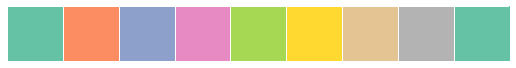

In [12]:
nb_loc = len(data[['loc', 'lon', 'lat']].drop_duplicates())
color_palette = sns.color_palette("Set2", nb_loc)
sns.palplot(color_palette)

In [13]:
col_idx = 0
for row in data[['loc', 'lon', 'lat']].drop_duplicates().itertuples():
    location, lon, lat = row[1:4]
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup='<i>' + location + '</i>',
                        color=color_palette.as_hex()[col_idx],
                        fill=True,
                        fill_color=color_palette.as_hex()[col_idx],
                        fill_opacity=0.8,
                        line_opacity=0.8
                       ).add_to(map_loc)
    col_idx += 1

In [14]:
map_loc

### The case of Particulate Matter 10 [pm10]

http://www.who.int/mediacentre/factsheets/fs313/en/ guidelines:
* Limit daily average per day 50 ug/m3
* Limit yearly average per day 40 ug/m3

In [15]:
pm10 = data[data.param == 'pm10']

In [16]:
pm10.head()

,city,lon,lat,time,loc,param,unit,value
3,Bangkok,100.486604,13.727559,2017-11-21T16:00:00+07:00,"Intarapitak Rd., Thon Buri",pm10,µg/m³,27.0
4,Bangkok,100.605741,13.666116,2017-11-21T16:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,26.0
14,Bangkok,100.505812,13.668461,2017-11-21T16:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,28.0
21,Bangkok,100.536494,13.729830,2017-11-21T15:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,35.0
25,Bangkok,100.547345,13.708041,2017-11-21T15:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,21.0


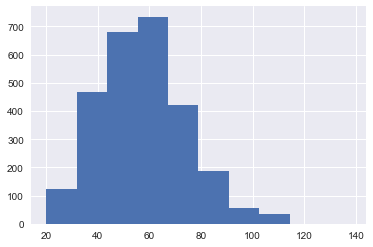

In [17]:
pm10['value'].hist()

In [18]:
locations = data[['loc', 'lon', 'lat']].drop_duplicates()['loc'].values

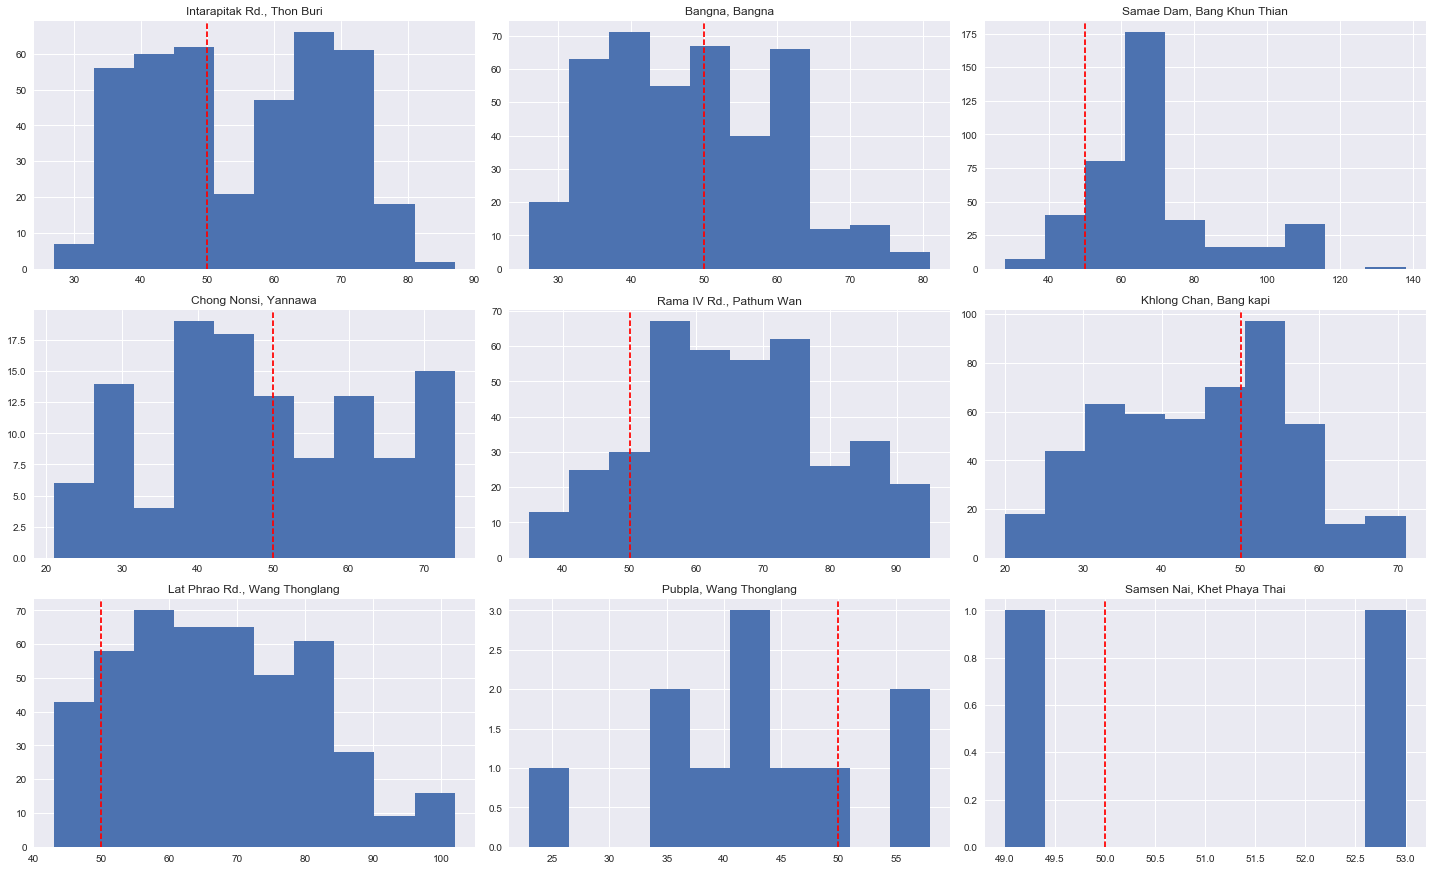

In [19]:
plt.rcParams['figure.figsize'] = (20, 20)
def draw_histograms_by_loc(n_rows, n_cols):
    locations = data[['loc', 'lon', 'lat']].drop_duplicates()['loc'].values
    fig = plt.figure()
    #plt.title("PM10 concentration")
    for i, loc in enumerate(locations):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        pm10[pm10['loc'] == loc]['value'].hist(bins=10, ax=ax)
        plt.axvline(x=50, color='r', linestyle='--')
        ax.set_title(loc)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms_by_loc(5, 3)

### Exploring time dimensions

In [20]:
pm10.head(20)

,city,lon,lat,time,loc,param,unit,value
3,Bangkok,100.486604,13.727559,2017-11-21T16:00:00+07:00,"Intarapitak Rd., Thon Buri",pm10,µg/m³,27.0
4,Bangkok,100.605741,13.666116,2017-11-21T16:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,26.0
14,Bangkok,100.505812,13.668461,2017-11-21T16:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,28.0
21,Bangkok,100.536494,13.729830,2017-11-21T15:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,35.0
25,Bangkok,100.547345,13.708041,2017-11-21T15:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,21.0
28,Bangkok,100.486604,13.727559,2017-11-21T15:00:00+07:00,"Intarapitak Rd., Thon Buri",pm10,µg/m³,27.0
30,Bangkok,100.636548,13.781520,2017-11-21T15:00:00+07:00,"Khlong Chan, Bang kapi",pm10,µg/m³,20.0
34,Bangkok,100.605741,13.666116,2017-11-21T15:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,26.0
36,Bangkok,100.505812,13.668461,2017-11-21T15:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,29.0
41,Bangkok,100.547345,13.708041,2017-11-21T14:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,21.0


In [21]:
pm10_rot = pm10.set_index(pd.DatetimeIndex(pm10['time']), inplace=False)

In [22]:
pm10_rot.head()

,city,lon,lat,time,loc,param,unit,value
time,,,,,,,,
2017-11-21 09:00:00,Bangkok,100.486604,13.727559,2017-11-21T16:00:00+07:00,"Intarapitak Rd., Thon Buri",pm10,µg/m³,27.0
2017-11-21 09:00:00,Bangkok,100.605741,13.666116,2017-11-21T16:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,26.0
2017-11-21 09:00:00,Bangkok,100.505812,13.668461,2017-11-21T16:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,28.0
2017-11-21 08:00:00,Bangkok,100.536494,13.729830,2017-11-21T15:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,35.0
2017-11-21 08:00:00,Bangkok,100.547345,13.708041,2017-11-21T15:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,21.0


In [23]:
# Now comes the magic of Pandas
pm10_rot = pm10_rot.pivot(columns='loc', values='value')

In [24]:
pm10_rot.head()

loc,"Bangna, Bangna","Chong Nonsi, Yannawa","Intarapitak Rd., Thon Buri","Khlong Chan, Bang kapi","Lat Phrao Rd., Wang Thonglang","Pubpla, Wang Thonglang","Rama IV Rd., Pathum Wan","Samae Dam, Bang Khun Thian","Samsen Nai, Khet Phaya Thai"
time,,,,,,,,,
2017-10-31 08:00:00,NaN,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN
2017-10-31 09:00:00,NaN,NaN,NaN,56.0,83.0,NaN,68.0,NaN,NaN
2017-10-31 10:00:00,NaN,NaN,NaN,55.0,84.0,NaN,68.0,NaN,NaN
2017-10-31 11:00:00,NaN,NaN,NaN,55.0,84.0,NaN,67.0,NaN,NaN
2017-10-31 12:00:00,NaN,NaN,NaN,54.0,84.0,NaN,67.0,NaN,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11210ad68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114a305c0>], dtype=object)

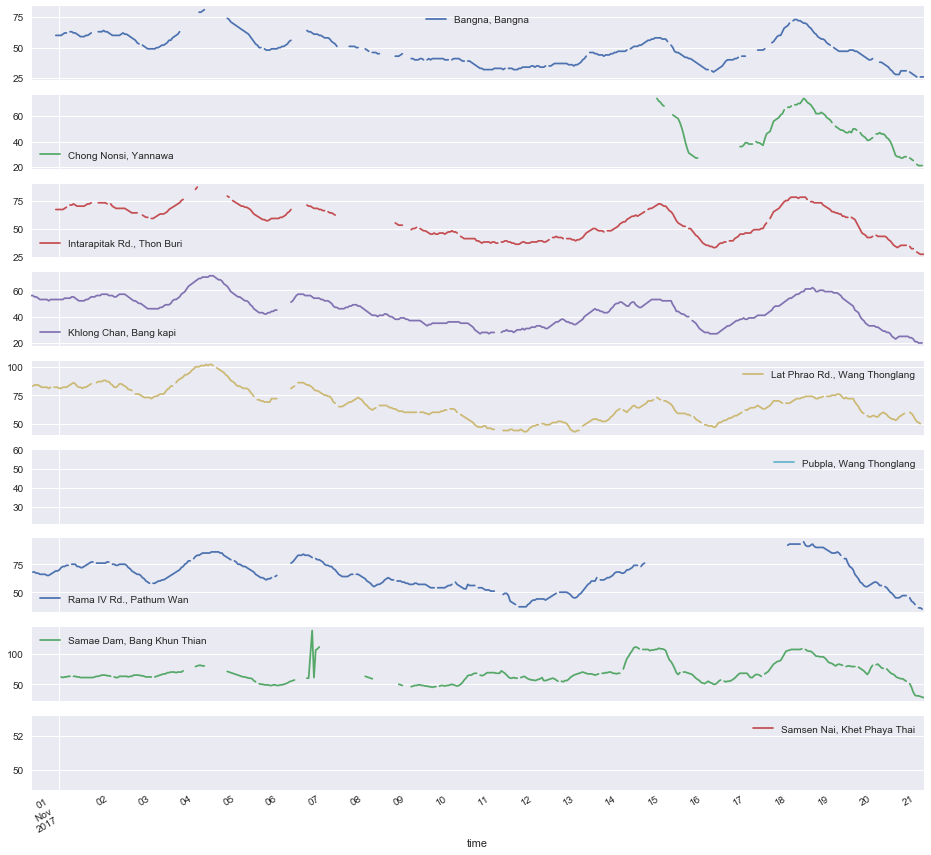

In [25]:
plt.rcParams['figure.figsize'] = (16, 16)
pm10_rot.plot(subplots=True)

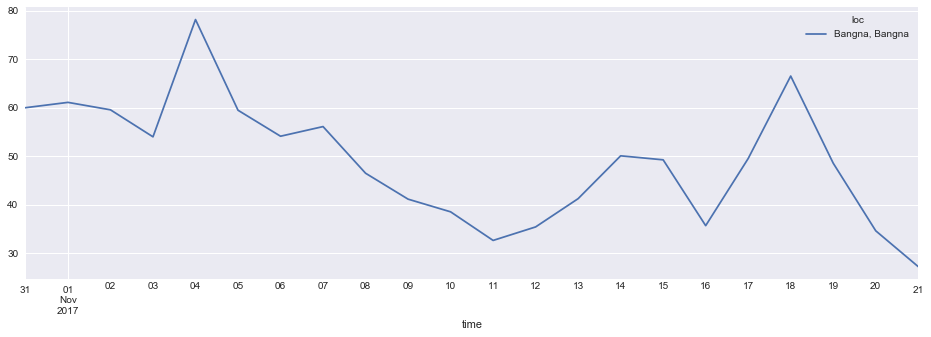

In [28]:
plt.rcParams['figure.figsize'] = (16, 5)
pm10_rot[['Bangna, Bangna']].resample('D').mean().plot()